In [26]:
import numpy as np
import pymc3 as pm
import pandas as pd
import theano as tt
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.odr import ODR, Model, Data, RealData

# Fitting with outliers

Outliers in a dataset may bias the results of model fitting. Here is my own implementation of the algorithms by David Hogg et al. 2010 and the example contributed to pymc3 documentation by Jonathan Sedar for fitting a line in the presence of outliers.

Our goal is to measure the slope and intercept of the best-fit line of the known correlation between the total infrared luminosity of galaxies and their peak wavelengths of infrared blackbody emission. The majority of galaxies in our sample obey this correlation with some intrinsic scatter, but there are outliers that bias our fit parameters (slope, intercept) if we do not account for them.  One method for accounting for outliers is to inspect the data and manually remove suspected outliers, but this is not scientific and may not be feasible given a large dataset. We implement an algorithm to determine the probability that each galaxy is an outlier while simultaneously finding the best-fit line based only on the inliers.

Notes:
* Hogg et al. 2010: https://arxiv.org/abs/1008.4686
* Jonathan Sedar example: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html
* Blackbody emission: https://en.wikipedia.org/wiki/Black_body

### Import the data. 
Each row in the pandas dataframe is a galaxy. 

- x values are the luminosities of each galaxy, or how bright they are in units of solar luminosities.
- y values are the wavelength of light where the blackbody emission peaks.
- errX and errY are the errors or standard deviations of each parameter, respectively.

https://en.wikipedia.org/wiki/Black_body

In [27]:
dFrame = pd.read_csv('data/galaxyData.csv', index_col=0)
print(dFrame.columns)

x = dFrame.LIR.values
y = dFrame.LPeak.values
errX = dFrame.errLIR.values
errY = dFrame.errLPeak.values

Index(['LIR', 'LPeak', 'errLPeak', 'errLIR'], dtype='object')


### Define the fit function
Choose a function that is a line in log-log space. Lam0 is the wavelength where the dust opacity is equal to 1, and eta is the powerlaw slope. When the luminosity, x, equals 1e12, the function equals lam0.

In [28]:
def fitFunc(x, lam0, eta):
    return lam0 * (x/1e12)**eta

### Confirm the outliers bias us
Before we move forward, let's just confirm that it's necessary to identify and remove outliers in the data in order to get a good fit to the overall correlation between luminosity and peak wavelength. We will fit a line to all the data using a simple orthogonal distance regression and plot it.

In [29]:
# define the same fit function but in a form that scipy ODR wants
def fitFuncODR(p, x):
    return p[0] * (x/1e12)**p[1]

model = Model(fitFuncODR)
data = RealData(x, y, errX, errY)
odr = ODR(data, model, beta0=[100.0, -0.06])  # beta0 is initial guess
odr.set_job(fit_type=2)  # fit_type=2 is ordinary least-squares
output = odr.run()

print('lam0: ' + str(output.beta[0]))
print('eta: ' + str(output.beta[1]))

# create fit line to plot
xfit = np.logspace(np.log10(np.min(x)), np.log10(np.max(x)))
yfit = np.logspace(np.log10(fitFuncODR(output.beta, np.min(x))), np.log10(fitFuncODR(output.beta, np.max(x))))

lam0: 102.24594872803407
eta: -0.04141554536845899


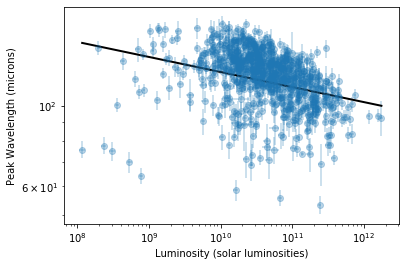

In [30]:
plt.errorbar(x, y, xerr=errX, yerr=errY, fmt='o', alpha=0.3)
plt.plot(xfit, yfit, color='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Luminosity (solar luminosities)')
plt.ylabel('Peak Wavelength (microns)')
plt.show()

### Residual plot
We can see that the best-fit line does not represent the bulk of the data. It is biased toward the outliers. Another way to look at this is to make a residual plot. A residual is the distance between the y data and the best fit (y - yfit). We will plot this below but scaled by the standard deviation in y so we can get a sense of scale for our residuals.

The line is biased toward the outliers.  One way to visualize this is to plot the distance between each datapoint and the best fit line. It should be symmetrical if it is well-fit.

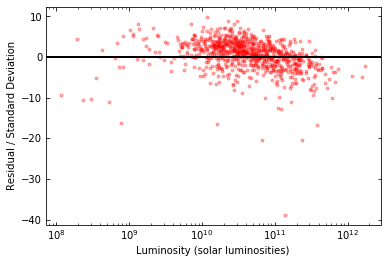

In [31]:
yInterp = interpolate.interp1d(xfit, yfit, bounds_error=False)
sortXInd = np.argsort(x)
yBestFit = yInterp(x[sortXInd])

fig, ax = plt.subplots()
ax.axes.tick_params(right='on',top='on',direction='in',which='both')
plt.plot(x, (y-yBestFit)/errY, 'r.', alpha=0.3)
plt.axhline(0, color='black', linewidth=2.0)
plt.ylabel('Residual / Standard Deviation')
plt.xlabel('Luminosity (solar luminosities)')
plt.xscale('log')
plt.show()

### Residuals suggest our fit is biased
Since there is structure in the residual plot, meaning the points aren't evenly distributed above and below the y=0 line, our fit is biased. We must proceed with the algorithm to remove outliers. For this we will use the python package, pymc3 to perform a Markov Chain Monte Carlo fit (MCMC). The advantage of MCMC is that it works well in high dimensional space. In the present example we will have a dimension for each of our ~800 galaxies. The disadvantage is that it is computationally slower than least squares fitting.

### How to fit while ignoring outliers
The MCMC routine will fit a line to the data while also evaluating the probability that each given galaxy belongs to the inlier or the outlier group. The line will be fit to the inlier group only. 

Galaxies identified as outliers are those that are many standard deviations (errY's) away from the best fit line in a given MC trial. The MCMC routine takes the outliers to be drawn from a Gaussian with a given mean and standard deviation that we do not care about in the end. We only care about identifying outliers and fitting a line to inliers. The inliers are also assumed to be drawn from a Gaussian distribution centered in y on the best-fit line.

In [32]:
with pm.Model() as model:
    # Define bounded flat priors for our fit parameters
    # Flat encodes our lack of prior knowledge about the true parameter values.
    # Bounded makes the priors proper in that the prior is now a probability distribution
    # We are justified in using these bounds because we suspect lam0 to be 100 and eta to be close to 0
    lam0 = pm.Bound(pm.Flat,lower=15, upper=1000)('lam0')
    eta = pm.Bound(pm.Flat,lower=-10, upper=10)('eta')

    # Define model for the inliers based on data and priors
    y_in = fitFunc(x, lam0, eta)

    # Define weakly informative priors for the mean and variance of outliers.
    # We do not care what the mean and standard deviation of the outliers are.
    # We simply want to model them so we can remove them.
    y_out = pm.Normal('yest_out', mu=100, sigma=50)
    sigma_y_out = pm.HalfNormal('sigma_y_out', sigma=20)

    # Use Bernoulli distribution to sample whether a datapoint is an inlier or outlier
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=x.shape[0]) # testval=np.random.rand(x.shape[0]) < 0.2)

    # Encode y and errY as theano objects as pymc3 runs on theano
    yobs = tt.shared(np.asarray(y, dtype=tt.config.floatX))
    sigma_y_in = np.asarray(errY, dtype=tt.config.floatX)

    # Set up normal distributions for inliers and outliers
    inliers = pm.Normal.dist(mu=y_in, sigma=sigma_y_in).logp(yobs)
    outliers = pm.Normal.dist(mu=y_out, sigma=sigma_y_in + sigma_y_out).logp(yobs)
    
    # Build custom likelihood that makes sure Bernoulli distribution talks to Gaussian likelihoods
    pm.Potential('obs', ((1 - is_outlier) * inliers).sum() + (is_outlier * outliers).sum())

with model:
    step = pm.NUTS(target_accept=0.8)
    tr = pm.sample(draws=2000, step=step, tune=1000, discard_tuned_samples=True)

print('\nSummary of trace: ')
print(pm.summary(tr).round(2))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, yest_out, eta, lam0]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [05:03<00:00, 39.49draws/s]
The acceptance probability does not match the target. It is 0.9070579554900801, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.



Summary of trace: 
                   mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
yest_out         116.50  1.27  114.15   118.88       0.03     0.02    2236.0   
is_outlier[0]      0.17  0.38    0.00     1.00       0.00     0.00    7193.0   
is_outlier[1]      0.15  0.36    0.00     1.00       0.00     0.00    6839.0   
is_outlier[2]      0.25  0.43    0.00     1.00       0.00     0.00    8720.0   
is_outlier[3]      0.82  0.38    0.00     1.00       0.00     0.00    7114.0   
is_outlier[4]      0.19  0.40    0.00     1.00       0.00     0.00    7581.0   
is_outlier[5]      0.99  0.10    1.00     1.00       0.00     0.00    5620.0   
is_outlier[6]      0.23  0.42    0.00     1.00       0.00     0.00    7993.0   
is_outlier[7]      0.24  0.42    0.00     1.00       0.00     0.00    7806.0   
is_outlier[8]      1.00  0.00    1.00     1.00       0.00     0.00    8000.0   
is_outlier[9]      0.33  0.47    0.00     1.00       0.00     0.00   12046.0   
is_outlier[10]     1

### Results
Our code has now returned the probability that each galaxy is an outlier as well as the best-fit parameters, lam0 and eta for inliers. We want to make a probability cut that we're comfortable with when deciding whether a galaxy is an outlier. If a galaxy is identified as an outlier in 99.7 percent of the MCMC trials we will choose to mark it as an outlier. Different applications of this algorithm might require different percentile cuts but 3 sigma or the 99.7 percentile is common in astronomy. Let's also print the number of inliers and outliers, save the inlier/outlier designation to our original pandas dataframe, and plot the results.

In [39]:
cutoffPercentile = 0.3  # Make a cut at 3 sigma (100-99.7)
dFrame['actual_outlier'] = np.percentile(tr['is_outlier'], cutoffPercentile, axis=0)

print('n_outliers:')
print(sum(dFrame.actual_outlier == 1))
print('\nn_inliers:')
print(sum(dFrame.actual_outlier == 0))

print('best lam0:')
print(np.median(tr.lam0))
print('\nbest eta:')
print(np.median(tr.eta))

n_outliers:
128

n_inliers:
686
best lam0:
98.82950237070968

best eta:
-0.07611598188768376


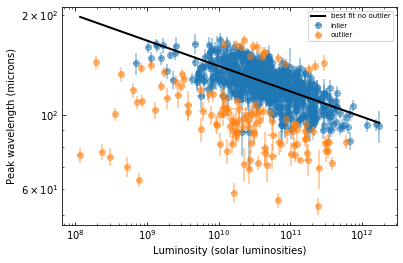

In [37]:
yfit_no_out = fitFunc(xfit, np.median(tr['lam0']), np.median(tr['eta']))

fig, ax = plt.subplots()
ax.axes.tick_params(right='on',top='on',direction='in',which='both')

plt.plot(xfit, yfit_no_out, linewidth=2.0, color='black', zorder=99, label='best fit no outlier')
plt.errorbar(dFrame.loc[dFrame.actual_outlier==0, 'LIR'],
             dFrame.loc[dFrame.actual_outlier==0, 'LPeak'],
             xerr=dFrame.loc[dFrame.actual_outlier==0, 'errLIR'],
             yerr=dFrame.loc[dFrame.actual_outlier==0, 'errLPeak'], fmt='o', alpha=0.5, label='inlier')
plt.errorbar(dFrame.loc[dFrame.actual_outlier==1, 'LIR'],
             dFrame.loc[dFrame.actual_outlier==1, 'LPeak'],
             xerr=dFrame.loc[dFrame.actual_outlier==1, 'errLIR'],
             yerr=dFrame.loc[dFrame.actual_outlier==1, 'errLPeak'], fmt='o', alpha=0.5, label='outlier')

plt.xlabel('Luminosity (solar luminosities)')
plt.ylabel('Peak wavelength (microns)')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize='x-small')
plt.show()

### Residual plot, inliers
Finally we plot the residual plot for inliers only:

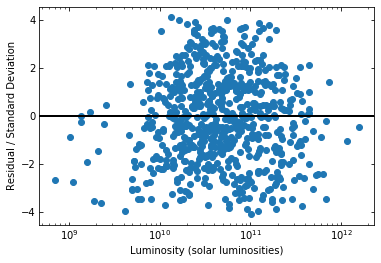

In [95]:
# Grab x, y, yerr of inliers
inlier_inds = dFrame.actual_outlier==0
x_in = dFrame.loc[inlier_inds, 'LIR'].values
y_in = dFrame.loc[inlier_inds, 'LPeak'].values
erry_in = dFrame.loc[inlier_inds, 'errLPeak'].values

# interpolate the best-fit line
xfit_in = np.logspace(np.log10(np.min(x_in)), np.log10(np.max(x_in)), 100)
yfit_in = fitFunc(xfit_in, np.ones(len(xfit_in))*np.median(tr['lam0']), np.ones(len(xfit_in))*np.median(tr['eta']))
yInterp = interpolate.interp1d(xfit_in, yfit_in, bounds_error=False)
yBestFit = yInterp(x_in)

# plot residual/errY vs x
fig, ax = plt.subplots()
ax.axes.tick_params(right='on',top='on',direction='in',which='both')
plt.scatter(x_in, (y_in-yBestFit)/erry_in)
plt.axhline(0, color='black', linewidth=2.0)
plt.ylabel('Residual / Standard Deviation')
plt.xlabel('Luminosity (solar luminosities)')
plt.xscale('log')
plt.show()

### Conclusion
There is no structure in the residual plot so we conclude our fit was successful. Said another way, the residual plot looks like a scatter plot centered about 0.

We may now use our knowledge of the best fit parameter values. Lam0_best = 98.8, and eta_best = -0.07.